In [64]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import pylops #
# from scipy import stats
# from scipy.stats import pearsonr as pearson
import helper_functions as hf
from tqdm import tqdm
# from sklearn.metrics import mean_absolute_percentage_error as MAPE

In [65]:
# Usando o Volve
#filename = "data/volve.sgy"

# Caso tenha o dado de ABL, descomentar a linha abaixo
filename = "D:/Dados ABL/ABL_FULL_TIME_3D.sgy"

if filename == "data/volve.sgy":
    ILINE = 30 # 500 - ABL
    XLINE = 101 # 1000 - VOLVE
else:
    ILINE = 500
    XLINE = 1000

In [ ]:
f = segyio.open(filename, ignore_geometry=True)

traces = segyio.collect(f.trace)[:]
ntraces, nt = traces.shape

t = f.samples
il = f.attributes(189)[:]
xl = f.attributes(193)[:]

# Define regular IL and XL axes
il_unique = np.unique(il)
xl_unique = np.unique(xl)

il_min, il_max = min(il_unique), max(il_unique)
xl_min, xl_max = min(xl_unique), max(xl_unique)

dt = t[1] - t[0]
dil = min(np.unique(np.diff(il_unique)))
dxl = min(np.unique(np.diff(xl_unique)))

ilines = np.arange(il_min, il_max + dil, dil)
xlines = np.arange(xl_min, xl_max + dxl, dxl)
nil, nxl = ilines.size, xlines.size

ilgrid, xlgrid = np.meshgrid(np.arange(nil),
                             np.arange(nxl),
                             indexing='ij')

# Look-up table
traces_indeces = np.full((nil, nxl), np.nan)
iils = (il - il_min) // dil
ixls = (xl - xl_min) // dxl
traces_indeces[iils, ixls] = np.arange(ntraces)
traces_available = np.logical_not(np.isnan(traces_indeces))

# Reorganize traces in regular grid
d = np.zeros((nil, nxl, nt))
d[ilgrid.ravel()[traces_available.ravel()],
  xlgrid.ravel()[traces_available.ravel()]] = traces

nil, nxl, nt = len(ilines), len(xlines), len(t)

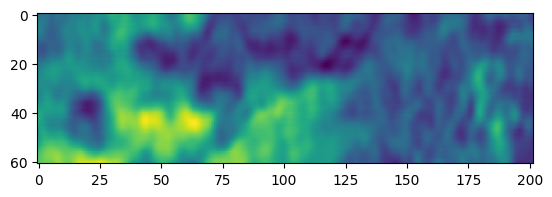

In [ ]:
plt.imshow(d[..., 200])

29.528549194335938


Text(0.5, 1.0, 'Seção Sísmica')

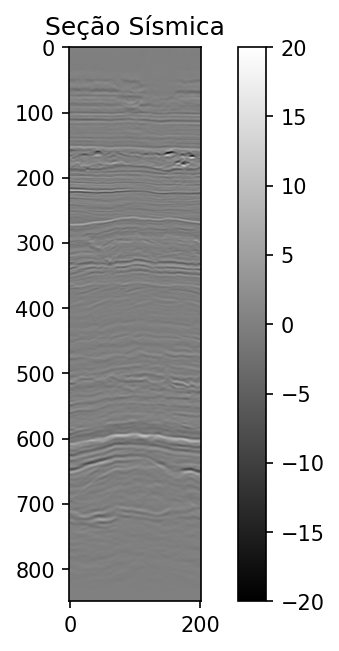

In [ ]:
# d = d / np.max(d)
print(np.max(d))

plt.figure(dpi=150)

plt.imshow(d[60, :, :].T, vmin=-20, vmax=20, cmap="gray")
plt.colorbar()
plt.title("Seção Sísmica")

Text(0.5, 1.0, 'Traço sísmico iline 30 e xline 101')

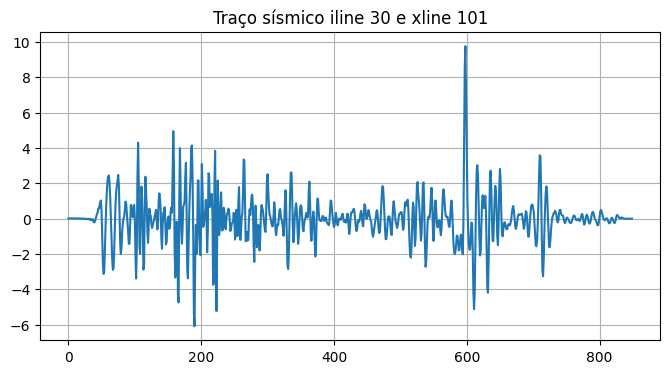

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(d[30, 101, :])
plt.grid()
plt.title("Traço sísmico iline 30 e xline 101")

In [ ]:
d.shape

(61, 202, 850)

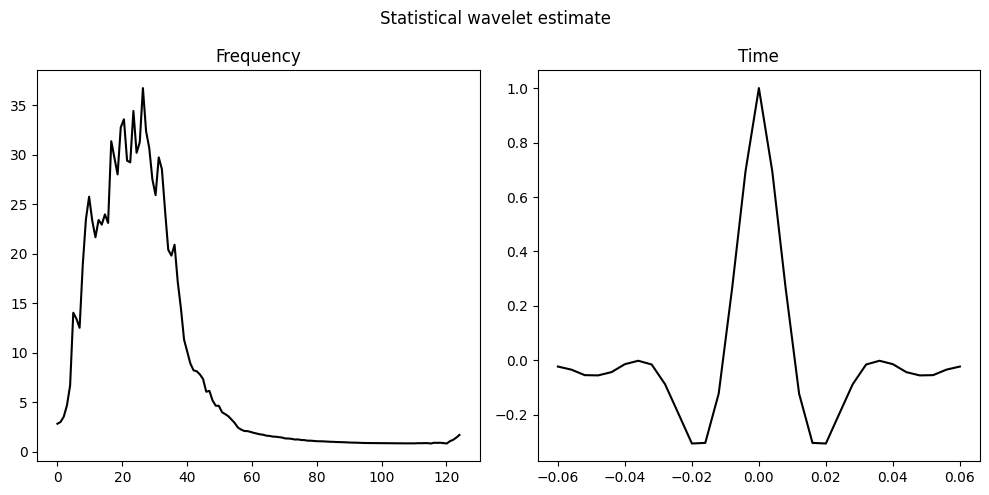

In [ ]:
def estimate_wavelet(d, dt):
    """
    Estimate the wavelet from seismic data.

    Parameters:
    d (np.ndarray): The seismic data array.
    dt (float): The sampling interval in milliseconds.

    Returns:
    tuple: A tuple containing the wavelet time axis, estimated wavelet, and wavelet spectrum.
    """
    # Wavelet time axis
    t_wav = np.arange(16) * (dt / 1000)
    t_wav = np.concatenate((np.flipud(-t_wav[1:]), t_wav), axis=0)

    # Estimate wavelet spectrum
    wav_est_fft = np.mean(np.abs(np.fft.fft(d[::2, ::2, int(2500 // dt):int(3500 // dt)], 2**8, axis=-1)), axis=(0, 1))
    fwest = np.fft.fftfreq(2**8, d=dt / 1000)

    # Create wavelet in time
    wav_est = np.real(np.fft.ifft(wav_est_fft)[:16])
    wav_est = np.concatenate((np.flipud(wav_est[1:]), wav_est), axis=0)
    wav_est = wav_est / wav_est.max()

    return t_wav, wav_est, fwest, wav_est_fft

# Call the function
t_wav, wav_est, fwest, wav_est_fft = estimate_wavelet(d, dt)

# Display wavelet
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Statistical wavelet estimate')
axs[0].plot(fwest[:2**8//2], wav_est_fft[:2**8//2], 'k')
axs[0].set_title('Frequency')
axs[1].plot(t_wav, wav_est, 'k')
axs[1].set_title('Time');
plt.tight_layout()

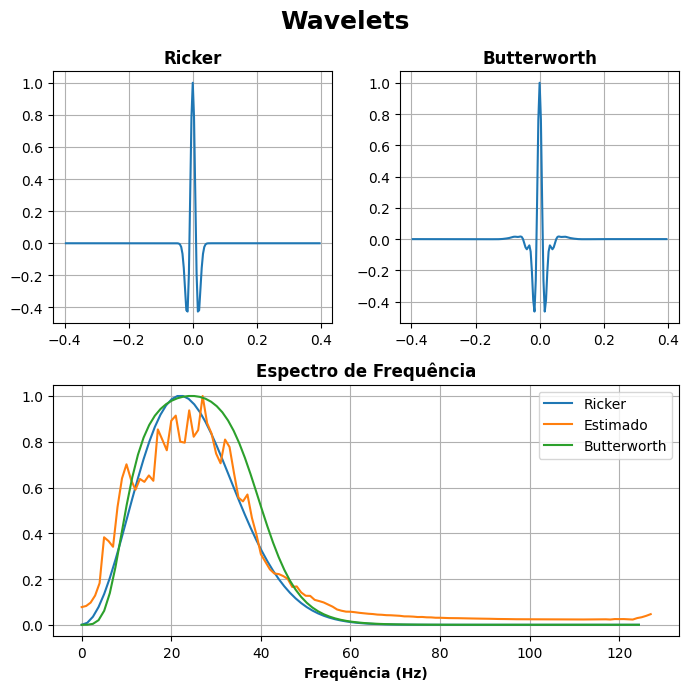

In [ ]:
sample = 100
dt = 4
pkfq = 22
highfq = 40
lowfq = 10

twlet, wlet, freqs, fft = hf.generate_ricker(peak_freq=pkfq, samples=sample, dt=dt)
twlet_b, wlet_b, freqs_b, fft_b = hf.generate_butter(
    freq_hi=highfq, freq_low=lowfq, samples=sample, dt=dt
)

plt.figure(figsize=(7, 7))

plt.suptitle("Wavelets", fontsize=18, fontweight="bold")

plt.subplot2grid((2, 2), (0, 0))
plt.plot(twlet, wlet)
plt.tick_params(axis="both")
plt.title("Ricker", fontweight="bold")
plt.grid()

plt.subplot2grid((2, 2), (0, 1))
plt.plot(twlet_b, wlet_b)
plt.tick_params(axis="both")
plt.title("Butterworth", fontweight="bold")
plt.grid()

teste = wav_est_fft[:2**8//2]

plt.subplot2grid((2, 2), (1, 0), colspan=2)
plt.tick_params(axis="both")
plt.plot(freqs, fft, label="Ricker")
plt.plot(teste / np.max(teste), label="Estimado")
plt.title(
    "Espectro de Frequência", fontweight="bold"
)
plt.plot(freqs_b, fft_b, label="Butterworth")
plt.xlabel("Frequência (Hz)", fontweight="bold")
plt.legend(loc="upper right")
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
nx, ny, nz = d.shape
print(nx, ny, nz)

61 202 850


In [ ]:
d_inv2_ppop = pylops.avo.poststack.PoststackLinearModelling(
    wlet / 2, nt0=nz, spatdims=1, explicit=False
)

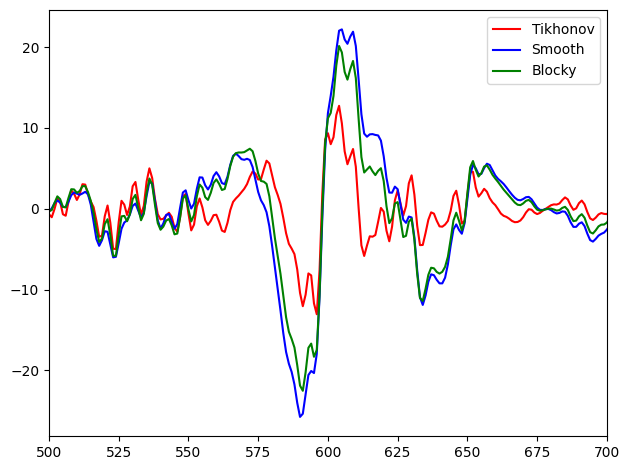

In [ ]:
d_inv2_tikho = (
    pylops.regularized_inversion(
        Op=d_inv2_ppop,
        y=d[ILINE, XLINE, :],
        Regs=[pylops.Identity(nz)],
        epsRs=[0.1],
        x0=np.zeros(d[ILINE, XLINE, :].shape),
        engine="scipy",
        **dict(iter_lim=1000)
    )[0]
)

d2op = pylops.SecondDerivative(nz)

d_inv2_smooth = (
    pylops.regularized_inversion(
        Op=d_inv2_ppop,
        y=d[ILINE, XLINE, :],
        Regs=[d2op],
        epsRs=[0.2],
        x0=np.zeros(d[ILINE, XLINE, :].shape),
        engine="scipy",
        **dict(iter_lim=1000)
    )[0]
)

d2op = pylops.FirstDerivative(nz)

d_inv2_blocky = (
    pylops.regularized_inversion(
        Op=d_inv2_ppop,
        y=d[ILINE, XLINE, :],
        Regs=[d2op],
        epsRs=[0.15],
        x0=np.zeros(d[ILINE, XLINE, :].shape),
        engine="scipy",
        **dict(iter_lim=1000)
    )[0]
)

plt.plot(d_inv2_tikho, color = 'red', label="Tikhonov")
plt.plot(d_inv2_smooth, color = 'blue', label="Smooth")
plt.plot(d_inv2_blocky, color = 'green', label="Blocky")

plt.xlim(500, 700)
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

Post-stack seismic modelling is the process of constructing seismic post-stack data from a profile of an elastic parameter (Impedance or Velocity) of choice in time (or depth) domain. This can be easily achieved using the following forward model:

$$ d(t, \theta = 0) = w (t) \cdot \frac{d \ln m(t)}{dt} $$

where $m(t)$ is the elastic parameter profile and $w (t)$ is the time domain seismic wavelet. In compact form:

$$ \text{d} = \textbf{WDm} $$

In the special case of acoustic impedance ($m(t) = AI(t)$), the modelling operator can be used to create zero-offset data:

$$ d(t, \theta = 0) = \frac{1}{2} w (t) \cdot \frac{d \ln m(t)}{dt} $$

where the scaling factor $\frac{1}{2}$ can be easily included in the wavelet

In [ ]:
nx , ny , nz = data_amp.shape

PostStackOperator = pylops.avo.poststack.PoststackLinearModelling(
    wlet / 2, nt0=nz, spatdims=1, explicit=True
)

c:\Users\aalbano\AppData\Local\Programs\Python\Python313\Lib\site-packages\pylops\utils\signalprocessing.py:46: FutureWarning: A new implementation of convmtx is provided in v2.2.0 to match MATLAB's convmtx method as stated in the docstring. The implementation of convmtx provided prior to v2.2.0 was instead not consistent with the documentation. Users are highly encouraged to modify their codes accordingly.
  warnings.warn(
